In [5]:
import numpy as np
import numba as nb
import xarray as xr
import rioxarray
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio.enums import Resampling
%config InlineBackend.figure_format = 'retina'

In [6]:
@nb.stencil(cval=0)
def std_kernel(x):
    return np.sqrt((
        (x[0,1]-x[0,0])**2+
        (x[1,0]-x[0,0])**2+
        (x[0,-1]-x[0,0])**2+
        (x[-1,0]-x[0,0])**2+
        (x[1,1]-x[0,0])**2+
        (x[1,-1]-x[0,0])**2+
        (x[-1,1]-x[0,0])**2+
        (x[-1,-1]-x[0,0])**2
    )/8)

In [7]:
dem_frame = xr.open_dataset(r"E:\risk_evaluation\scripts\datas\DEM-90\extracted\DEM_SRTM.tif").squeeze("band", drop=True)
dem_frame

<xarray.Dataset>
Dimensions:      (x: 15601, y: 18223)
Coordinates:
  * x            (x) float64 110.0 110.0 110.0 110.0 ... 123.0 123.0 123.0 123.0
  * y            (y) float64 43.18 43.18 43.18 43.18 ... 28.0 28.0 28.0 28.0
    spatial_ref  int32 ...
Data variables:
    band_data    (y, x) float32 ...

In [8]:
dem_frame_array = dem_frame.band_data.to_numpy()

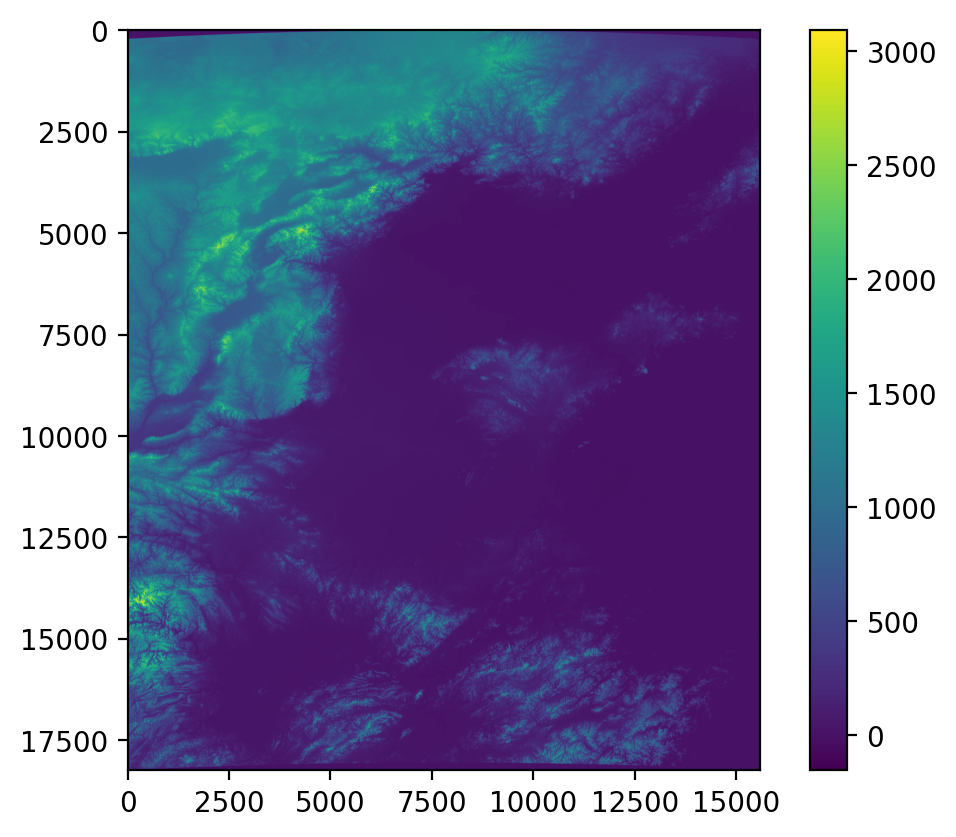

In [9]:
plt.imshow(dem_frame_array)
plt.colorbar()

In [10]:
dem_std = std_kernel(dem_frame_array)

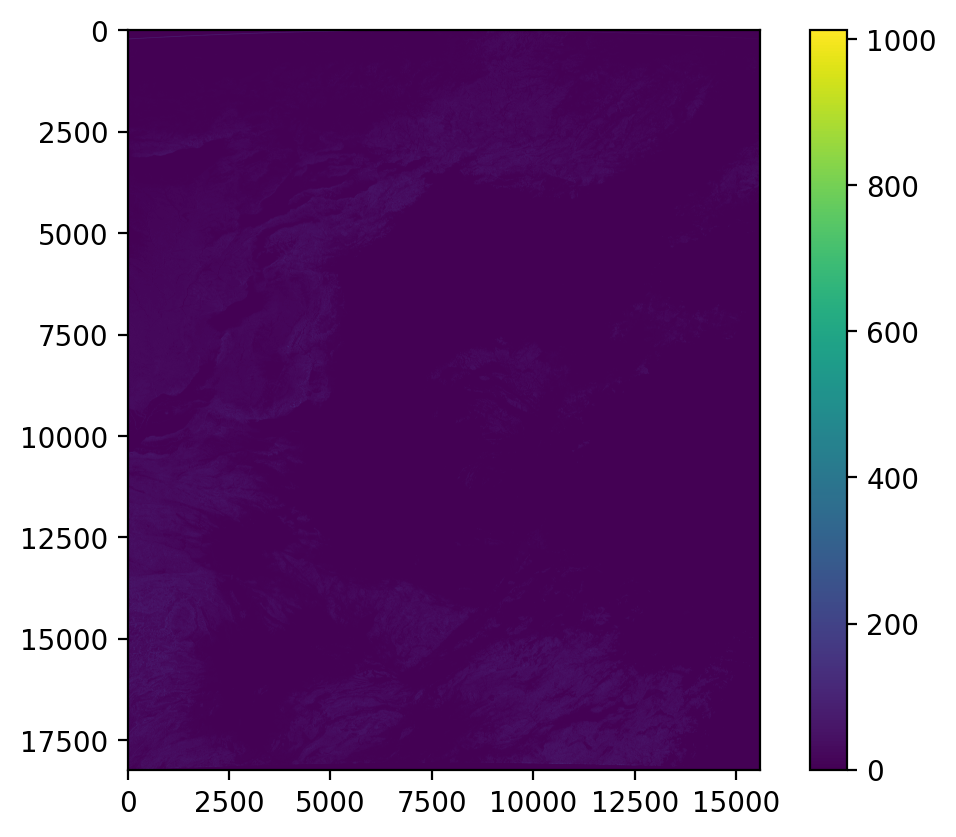

In [11]:
plt.imshow(dem_std)
plt.colorbar()

In [12]:
dem_std_dataset = xr.Dataset(
    data_vars=dict(
        dem_std=(["y","x"], dem_std)
    ),
    coords=dict(
        x=dem_frame.x,
        y=dem_frame.y
    )
)


In [13]:
dem_std_dataset.rio.write_crs("EPSG:4326", inplace=True)
dem_std_dataset.rio.write_coordinate_system(inplace=True)
dem_std_dataset.rio.write_transform(inplace=True)

<xarray.Dataset>
Dimensions:      (y: 18223, x: 15601)
Coordinates:
  * x            (x) float64 110.0 110.0 110.0 110.0 ... 123.0 123.0 123.0 123.0
  * y            (y) float64 43.18 43.18 43.18 43.18 ... 28.0 28.0 28.0 28.0
    spatial_ref  int32 0
Data variables:
    dem_std      (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [14]:
dem_std_dataset_resampled = dem_std_dataset.rio.reproject("EPSG:4326", shape=(1800,1560),resampling=Resampling.nearest)

In [15]:
dem_std_dataset_resampled.dem_std.rio.write_nodata(32767, inplace=True,encoded=True)

<xarray.DataArray 'dem_std' (y: 1800, x: 1560)>
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [17.25905559, 25.03996805, 10.37424696, ...,  0.        ,
         0.        ,  0.        ],
       [10.84550598, 13.91941091, 18.19684039, ...,  0.        ,
         0.        ,  0.        ],
       [11.9058809 ,  9.33407735, 15.99609327, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
  * x            (x) float64 110.0 110.0 110.0 110.0 ... 123.0 123.0 123.0 123.0
  * y            (y) float64 43.18 43.17 43.16 43.16 ... 28.03 28.02 28.01 28.0
    spatial_ref  int32 0

In [18]:
dem_std_dataset_resampled.dem_std.rio.to_raster(r"E:\risk_evaluation\scripts\outputs\DEM-90\DEM_SRTM_std.tif")

In [22]:
res_frame = gpd.read_file("/home/zyzh0/coding/risk_evaluation/scripts/datas/BOARDER/extracted/华北平原地市级/华北平原地市级.shp")
res_frame.dissolve()

,geometry,OBJECTID,省,省代码,市,市代码,市类型,省类型,面积,Shape_Leng,Shape_Area
0,"MULTIPOLYGON (((116.71529 30.05644, 116.70969 ...",1,安徽省,340000,安庆市,340800,地级市,省,13488.8,6.308934,1.268428


In [23]:
dem_std_dataset_resampled_clipped = dem_std_dataset_resampled.rio.clip(res_frame.geometry.values, res_frame.crs, drop=True)

In [14]:
dem_std_dataset_resampled_clipped

<xarray.Dataset>
Dimensions:      (x: 1482, y: 1567)
Coordinates:
  * x            (x) float64 110.4 110.4 110.4 110.4 ... 122.7 122.7 122.7 122.7
  * y            (y) float64 42.62 42.61 42.6 42.59 ... 29.43 29.42 29.41 29.4
    spatial_ref  int64 0
Data variables:
    dem_std      (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan

In [24]:
np.nanmax(dem_std_dataset_resampled_clipped.dem_std.values)

99.04336406931921

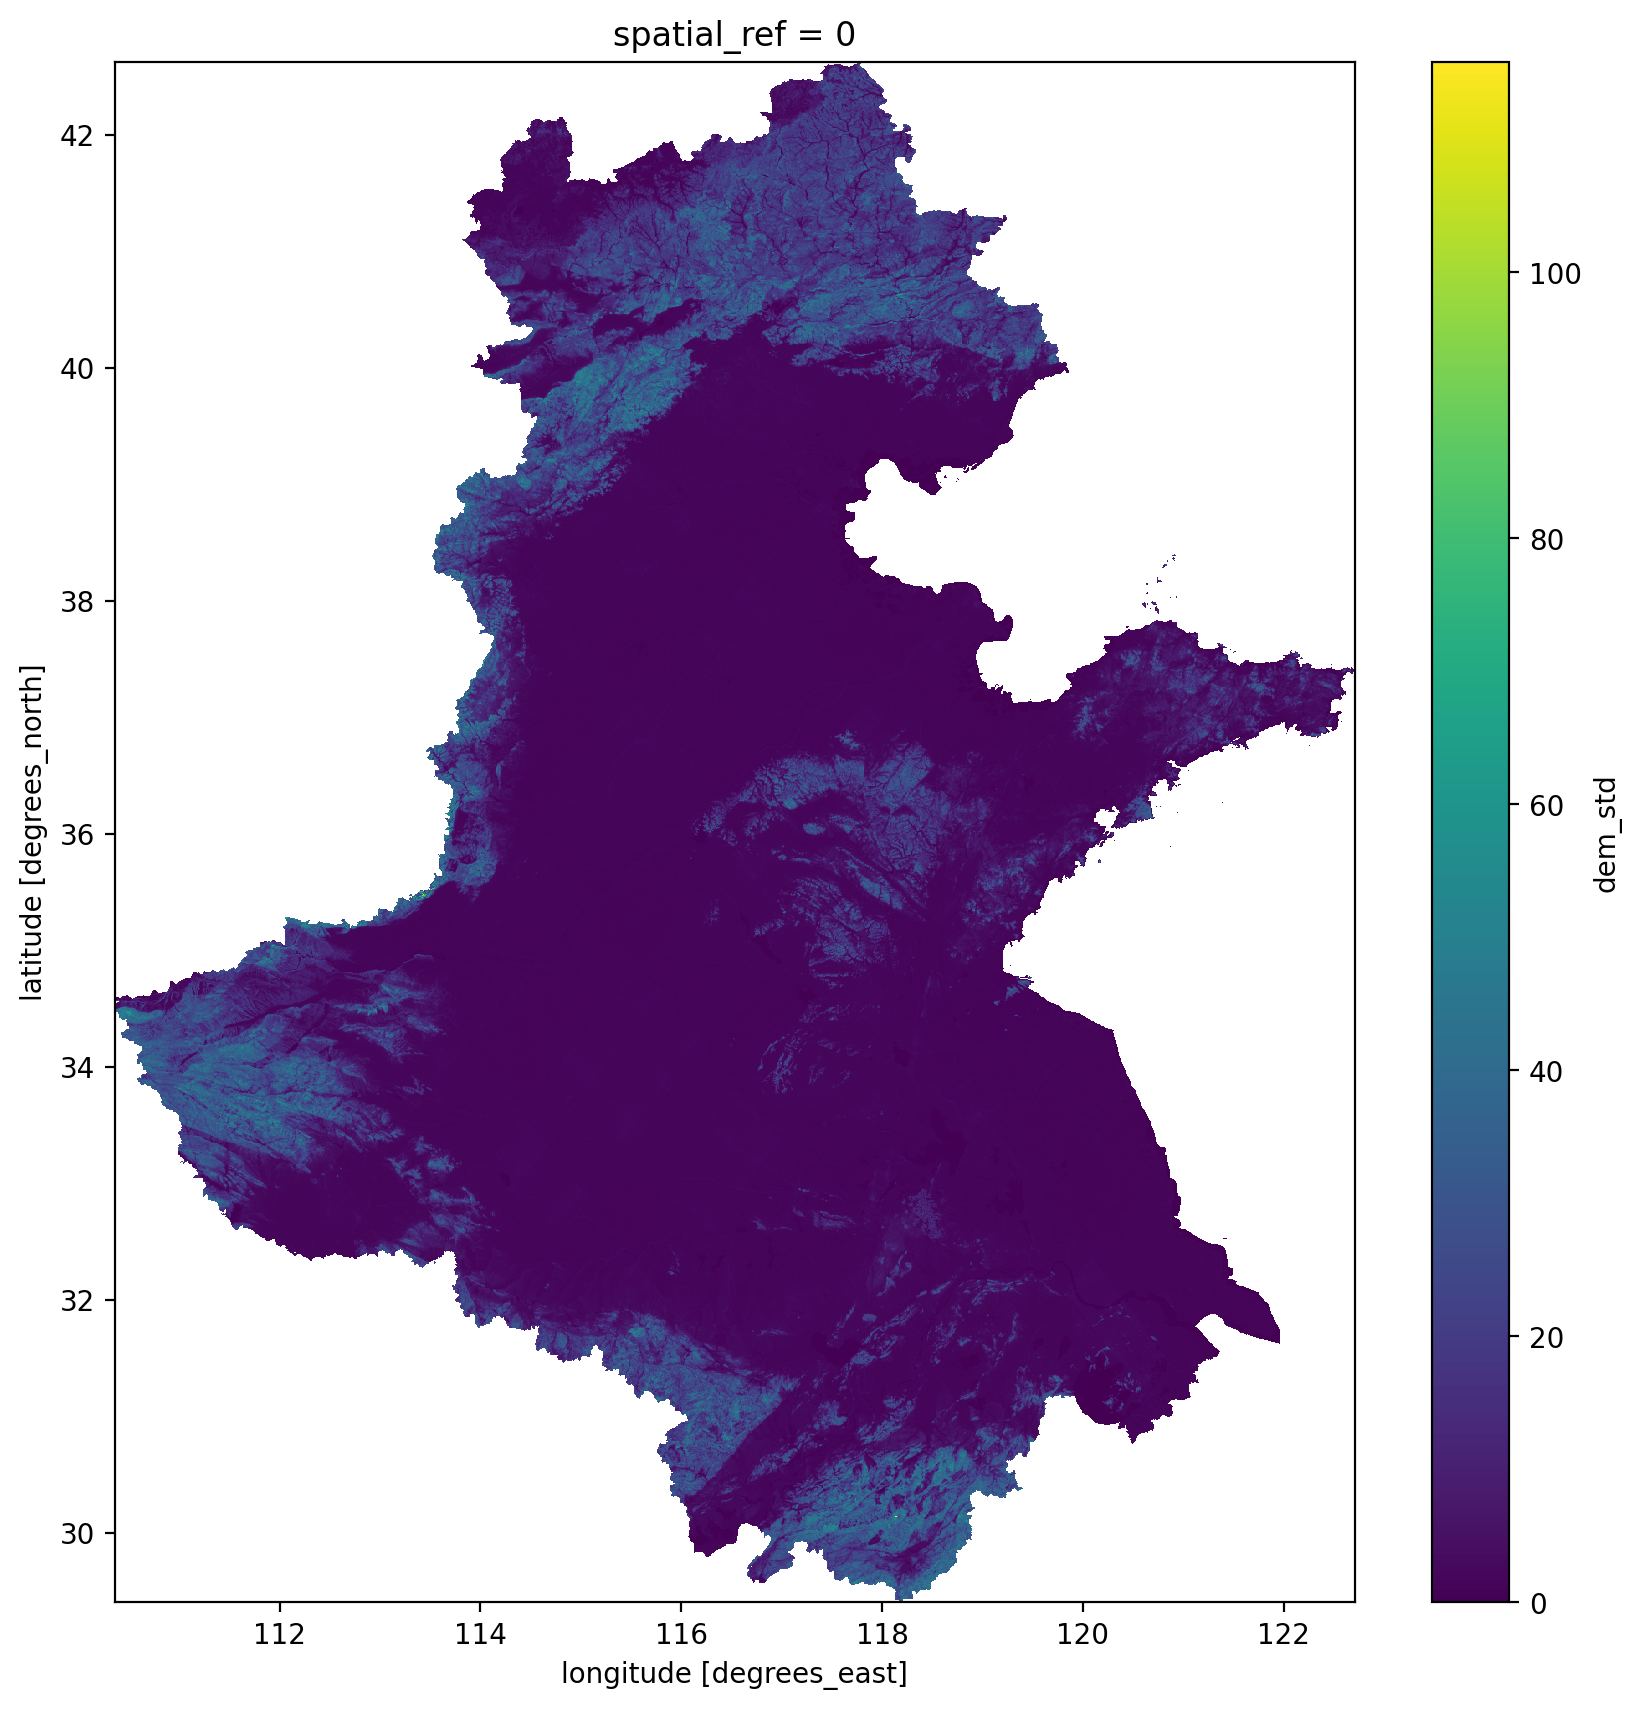

In [18]:
fig,ax = plt.subplots(figsize=(10,10))
dem_std_dataset_resampled_clipped.dem_std.plot(ax=ax)

In [26]:
dem_std_dataset_resampled_clipped.rio.to_raster("/home/zyzh0/coding/risk_evaluation/scripts/datas/DEM-90/extracted/DEM_SRTM_std.tif")